In [1]:
# Copyright (c) 2020 Urbain Vaes. All rights reserved.
#
# This work is licensed under the terms of the MIT license.
# For a copy, see <https://opensource.org/licenses/MIT>.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.optimize

In [2]:
matplotlib.rc('font', size=20)
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex=False)
matplotlib.rc('figure', figsize=(14, 8))
matplotlib.rc('lines', linewidth=2)
matplotlib.rc('figure.subplot', hspace=.4)

# Simulation of Gaussian processes
In this section, we will explore different techniques for the simulation
of Gaussian processes. The techniques will be illustrated on a few
examples: Brownian motion,
[Brownian bridge](https://en.wikipedia.org/wiki/Brownian_bridge),
[Fractional Brownian motion](https://en.wikipedia.org/wiki/Fractional_Brownian_motion),
and [Ornstein–Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) (OU).
Below we will employ the same parametrization of the OU process as in the Wikipedia page:
$$
\newcommand{\d}{\mathrm d}
\newcommand{\e}{\mathrm e}
\newcommand{\cov}{\mathrm{cov}}
\newcommand{\var}{\mathrm{var}}
\d x_t = \theta (\mu -  x_t) \, \d t + \sigma \, \d W_t.
$$
When starting at a deterministic initial value $x_0$,
the mean and covariance of this process are given by:
$$
\mathbb E(x_t) = \mu + (x_0 - \mu) \, \e^{-\theta t}, \qquad \cov(x_s, x_t) = \frac{\sigma^2}{2\theta} \left( e^{-\theta|t-s|} - e^{-\theta(t+s)} \right).
$$
The covariance at stationarity, i.e. the covariance of the process when $x_0$
is random and distributed according to the invariant measure of the OU
process, is equal to $\cov(x_s, x_t) = \frac{\sigma^2}{2\theta} e^{-\theta |t-s|}$,
which can be obtained by letting $t$ and $s$ go to $+ \infty$ in the previous equation,
while keeping their difference fixed.

In [3]:
# Set the final time, number of time steps, and number of replicas.
T, n, m = 2, 100, 50

# Define the parameters for the OU process
theta, mu, sigma, x0 = 3, -1, .2, 1

s = np.linspace(0, T, n)
t = np.linspace(0, T, n)

# Define covariance function of the processes
covariance_functions = {
    'Brownian motion': lambda t, s:
        # np.minimum calculates the element-wise minimum
        np.minimum(t, s),
    'Brownian bridge': lambda t, s:
        # T is the final time
        np.minimum(s, t) * (T - np.maximum(s, t)) / T,
    'Fractional Brownian motion': lambda t, s, h=.8:
        # h is the Hurst index
        (1/2) * ((t**2)**h + (s**2)**h - ((t - s)**2)**h),
    'Ornstein-Uhlenbeck': lambda t, s:
        # theta and mu are the coefficients in the drift, sigma is the
        # diffusion, and x0 is the initial condition.
        sigma**2/(2*theta) * (np.exp(- theta * np.abs(t - s))
          - np.exp(- theta * np.abs(t + s)))
    }

# Mean of the processes (if not zero)
mean_functions = {'Ornstein-Uhlenbeck': lambda t:
        mu + (x0 - mu) * np.exp(-theta*t)}

## Direct simulation

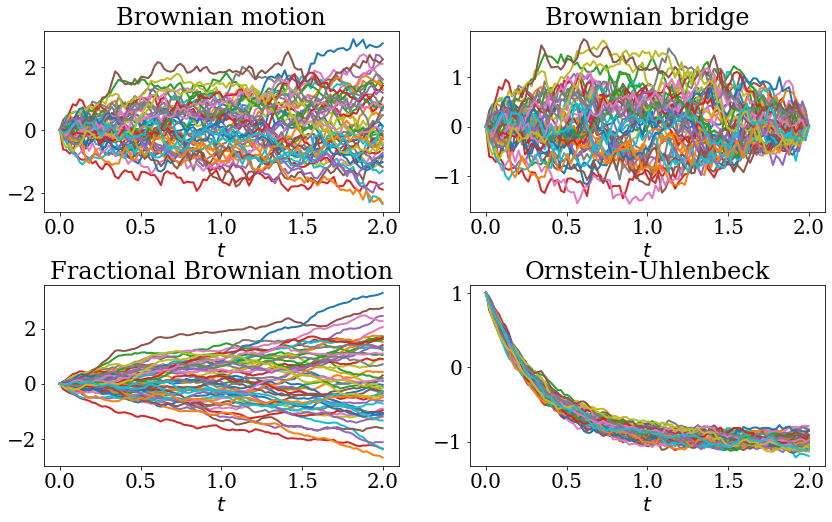

In [4]:
# Generate m samples from the standard mutivariate normal distribution,
# with which we will construct the other processes.
# (Each line is a sample from the Gaussian)
x = np.random.randn(m, n)

# Generate all (s, t) pairs - try this in a REPL to understand what it's doing.
grid_S, grid_T = np.meshgrid(s, t)

fig, ax = plt.subplots(2, 2)
ax = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]

# Sample from each process
for i, process in enumerate(covariance_functions):

    # Get covariance function of the process
    Sigmafunc = covariance_functions[process]

    # Calculate mean of the multivariate Gaussian
    mean = mean_functions[process](t) \
        if process in mean_functions else np.zeros(n)

    # Make the mean a column vector
    mean.shape = (n, 1)

    # Covariance matrix of the multivariate Gaussian
    Sigma = Sigmafunc(grid_S, grid_T)

    # Sigma needs to be positive definite to use the Cholesky factorization.
    # We will therefore use the matrix square root.
    # C = np.linalg.cholesky(Sigma)

    # Calculate factorization of Sigma
    C = np.real(la.sqrtm(Sigma))

    # Samples from the process
    x_process = mean + C.dot(x.T)

    # Plot the process
    ax[i].plot(s, x_process)
    ax[i].set_title(process)
    ax[i].set_xlabel('$t$')

plt.show()

## Simulation of Gaussian Markovian processes
If $X_t$ is a Gaussian Markovian process, then one needs only $X_{t_n}$ in
order to simulate $X_{t_{n+1}}$, so we can simulate Gaussian processes using
an iterative procedure. We recall from the lecture notes that if $X = (X_1,
X_2)^T \sim \mathcal N(m, \Sigma)$, then the conditional distribution of
$X_2$ conditional on $X_1$ is a normal  with
$$
\begin{aligned}
& \mathbb E(X_2 | X_1) = m_2 + \Sigma_{21} \Sigma_{11}^{-1} (X_1 - m_1), \\
& \var(X_2 | X_1) = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}.
\end{aligned}
$$
In the case of Brownian motion, letting $X_2 = W_t$ and $X_1 = W_s$ with $s \leq t$,
these formulae imply
$$
\begin{aligned}
&\mathbb E(W_t | W_s) = W_s, \\
&\var(W_t | W_s) = t - s.
\end{aligned}
$$
(Of course, we also know this from the properties of Brownian motion.)
To simulate Brownian paths, we can therefore employ the update formula
$$
W_{t_{n+1}} = W_{t_n} + \sqrt{t_{n+1} - t_n} \, Z_{n+1},
$$
where $Z_{n + 1} \sim \mathcal N(0, 1)$.
In other words, the $n$-dimensional vector
$W = (W_1, \dots, W_N)$ defined by
$$
W_{i} = Z_1 + \sum_{k=2}^i  \sqrt{t_{k+1} - t_k} \, Z_k, \qquad i = 1, \dotsc, N,
$$
where $Z_i \sim \mathcal N(0, 1)$ are independent increments,
is equal in law to a Brownian motion discretized at the time points.
Below we apply the same technique to simulate the OU process.
$$
\begin{aligned}
X_{t_{n+1}}
&= m_{t_{n+1}} + \Sigma_{21} \Sigma_{11}^{-1} (X_{t_n} - m_{t_n}) + \sqrt{\Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}} \, Z_{n+1}, \qquad \Sigma = C(t_n, t_{n+1}), \\
&=: A_{n+1} + B_{n+1} \, X_{t_n} + C_{n+1} \, Z_{n+1}
\end{aligned}
$$

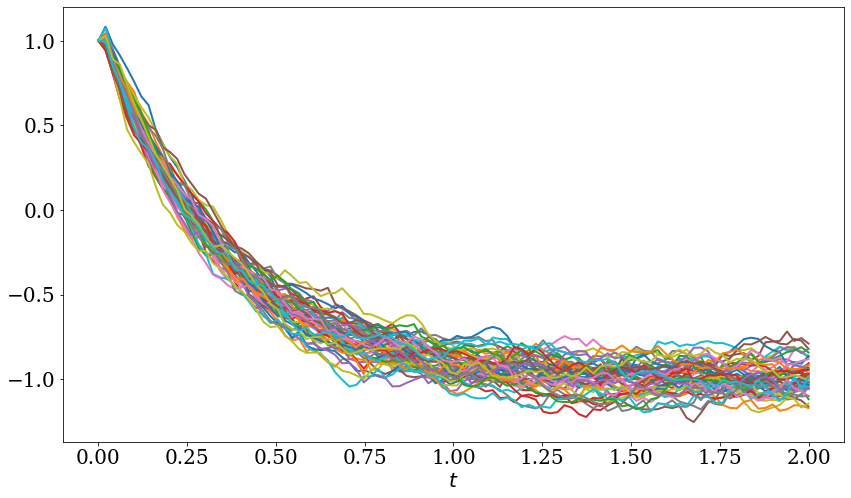

In [5]:
# Generate m x n normally distributed increments (the Z_i above)
z = np.random.randn(m, n)

Sigma_12 = covariance_functions['Ornstein-Uhlenbeck'](t[:-1], t[1:])
Sigma_11 = covariance_functions['Ornstein-Uhlenbeck'](t[:-1], t[:-1])
Sigma_22 = covariance_functions['Ornstein-Uhlenbeck'](t[1:], t[1:])
m1 = mean_functions['Ornstein-Uhlenbeck'](t[:-1])
m2 = mean_functions['Ornstein-Uhlenbeck'](t[1:])

# Since the initial condition is deterministic, we must treat the first entry
# differently from the other, because Sigma_11[0] = 0.
A, B, C = np.zeros(n - 1), np.zeros(n - 1), np.zeros(n - 1)
A[0], B[0], C[0] = 1, 0, np.sqrt(Sigma_22[0])
A[1:] = m2[1:] - (Sigma_12[1:]/Sigma_11[1:])*m1[1:]
B[1:] = (Sigma_12[1:]/Sigma_11[1:])
C[1:] = np.sqrt(Sigma_22[1:] - Sigma_12[1:]**2/Sigma_11[1:])

x = np.zeros((m, n))
x[:, 0] = x[:, 0] + x0
for i in range(n - 1):
    x[:, i+1] = A[i] + B[i]*x[:, i] + C[i]*z[:, i]

fig, ax = plt.subplots(1, 1)
ax.plot(t, x.T)
ax.set_xlabel('$t$')
plt.show()

## Simulation by transformation from Brownian motion

With this technique, we exploit the fact that
$$
B_t = W_t - (t/T) W_T
$$
and
$$
V_t = \mu + \frac{\sigma^2}{2\theta} e^{-\theta t} W(e^{2 \theta t})
$$
are a Brownian bridge and a (strictly and weakly) stationary
Orstein-Uhlenbeck process, respectively.
These two processes can therefore be simulated by transforming Brownian paths.

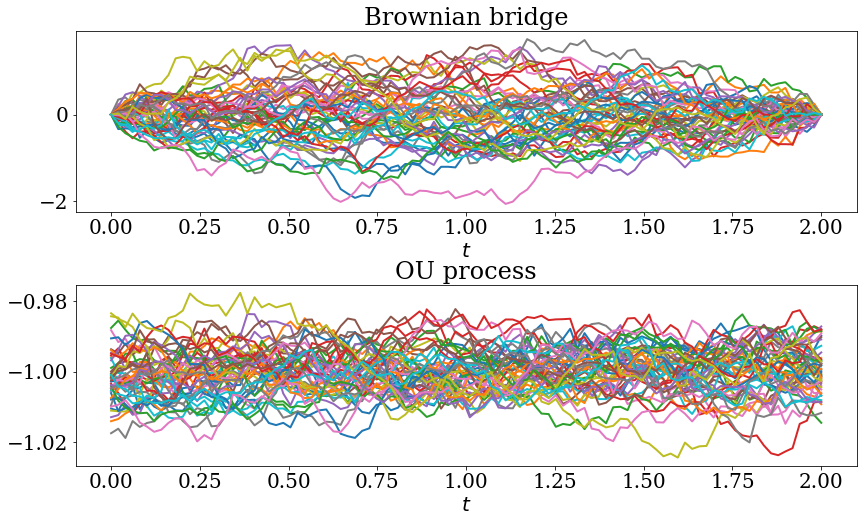

In [6]:
# Generate m x n normally distributed increments (the Z_i above)
z = np.random.randn(m, n)

# Generate two Brownian motions: one for the simulation of the Brownian bridge,
# and another one (with different time points) for the simulation of the
# stationary OU process.
mapped_times_bridge = t
mapped_times_ou = np.exp(2*theta*t)
multipliers_bridge = np.sqrt(np.diff([0, *mapped_times_bridge]))
multipliers_ou = np.sqrt(np.diff([0, *mapped_times_ou]))

# The way the operator '*' works in numpy might be counter-intuitive. In
# particular, it does not perform a matrix-vector product. Try, e.g., running
# 'np.arange(10)*np.ones((5, 10))' to understand how it works.
w_bridge = np.cumsum(multipliers_bridge * z, axis=1)
w_ou = np.cumsum(multipliers_ou * z, axis=1)

# Apply transformation
bridge = w_bridge - np.tensordot(w_bridge[:, -1], (t/T), axes=0)
ou = mu + sigma**2/(2*theta) * np.exp(-theta*t) * w_ou

# Plot the results
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, bridge.T)
ax[0].set_title("Brownian bridge")
ax[0].set_xlabel('$t$')
ax[1].plot(t, ou.T)
ax[1].set_title("OU process")
ax[1].set_xlabel('$t$')
plt.show()

## Karhunen-Loeve expansion
Since the Karhunen-Loeve expansions of the Brownian motion and the Brownian
bridge are presented in the lecture notes, here we calculate that of the OU
process in the case of a deterministic initial condition. By subtracting the
mean of the process, we obtain a Gaussian centered process for which the
Karhunen-Loeve theorem holds. We have solve the eigenvalue problem:
$$
\int_0^T C(s, t) \, \phi_n(s) \, \d s = \lambda_n \, \phi_n(t).
$$
Substituting the expression of $C(s, t)$ presented above and rearranging,
we obtain
$$
\int_0^T \left( e^{-\theta|t-s|} - e^{-\theta(t+s)} \right) \, \phi_n(s) \, \d s = \frac{2 \, \theta \, \lambda_n}{\sigma^2} \, \phi_n(t).
$$
From this equation we obtain that $\phi_n(0) = 0$.
Differentiating both sides with respect to $t$ and using the previous equation,
we obtain
$$
   \, - \theta \int_0^t e^{-\theta (t - s)} \, \phi_n(s) \, \d s + \theta \int_t^T e^{-\theta (s - t)} \, \phi_n(s) \, \d s - \theta \int_0^T e^{-\theta (s + t)} \, \phi_n(s) \, \d s  = \frac{2 \, \theta \, \lambda_n}{\sigma^2} \, \phi_n'(t),
$$
which implies $\phi_n'(T) = - \theta \, \phi_n(T)$.
Simplifying $\theta$,
differentiating both sides again,
and rearranging, we obtain
$$
\frac{2 \,\theta^2 \, \lambda_n}{\sigma^2} \phi_n(t) - 2 \phi_n(t) = \frac{2 \, \lambda_n}{\sigma^2} \, \phi_n''(t) \Leftrightarrow  \phi_n''(t) = \left(\theta^2 - \frac{\sigma^2}{\lambda_n}\right) \, \phi_n(t).
$$
Let us assume first that $\alpha_n^2 = \theta^2 - \frac{\sigma^2}{\lambda_n}$ is positive.
Then, employing the boundary condition $\phi_n(0) = 0$,
solutions are of the form $\phi_n = \sinh (\alpha_n t)$,
and substituting in the second boundary condition, we find that the $\alpha_n$ satisfy:
$$
\tanh(\alpha_n \, T) = - \frac{\alpha_n}{\theta}.
$$
Since both sides are even functions of $\alpha_n$,
and since the hyperbolic tangent is always positive when $\alpha_n > 0$,
we deduce that this equation does not admit a solution.
Solutions must therefore be of the type $\phi_n = \sin (\alpha_n t)$,
where $\alpha_n$ solves:
$$
\tan(\alpha_n \, T) = - \frac{\alpha_n}{\theta}.
$$
In order to solve this equation, we must resort to numerical simulation.

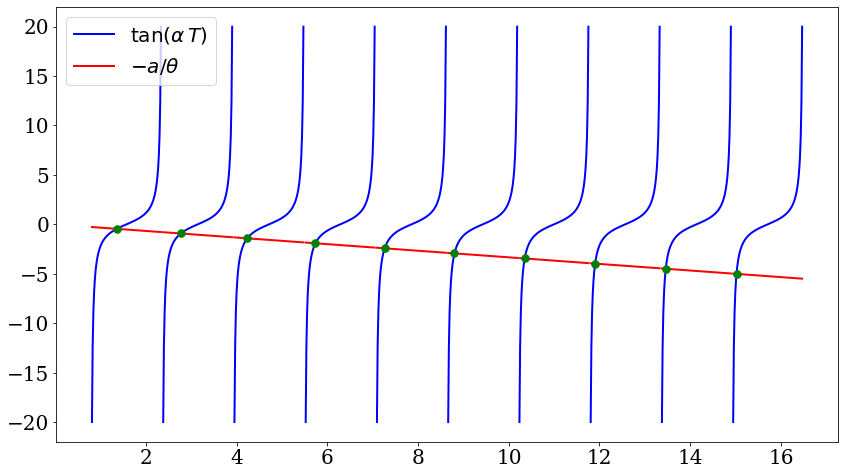

In [7]:
# Calculate the roots numerically
n_roots, roots = 100, []
for i in range(1, n_roots + 1):
    fun = lambda a: a*T + np.arctan(a/theta) - i*np.pi
    roots.append(scipy.optimize.root(fun, 0).x[0])
roots = np.array(roots)

# Plot the roots
periods = 10
alpha_range = (1/T)*np.linspace(- np.pi/2 + .05, np.pi/2 - .05, 100)
fig, ax = plt.subplots()
for i in range(periods):
    alpha = (i + 1)*(np.pi/T) + alpha_range
    if i == 0:
        ax.plot(alpha, np.tan(alpha*T), label=r"$\tan(\alpha \, T)$", color='b')
        ax.plot(alpha, - alpha/theta, label=r"$-a/\theta$", color='r')
    else:
        ax.plot(alpha, np.tan(alpha*T), color='b')
        ax.plot(alpha, - alpha/theta, color='r')
    ax.plot(roots[i], np.tan(roots[i]*T), marker='.',
            markersize=15, color='g')
    ax.legend()
plt.show()

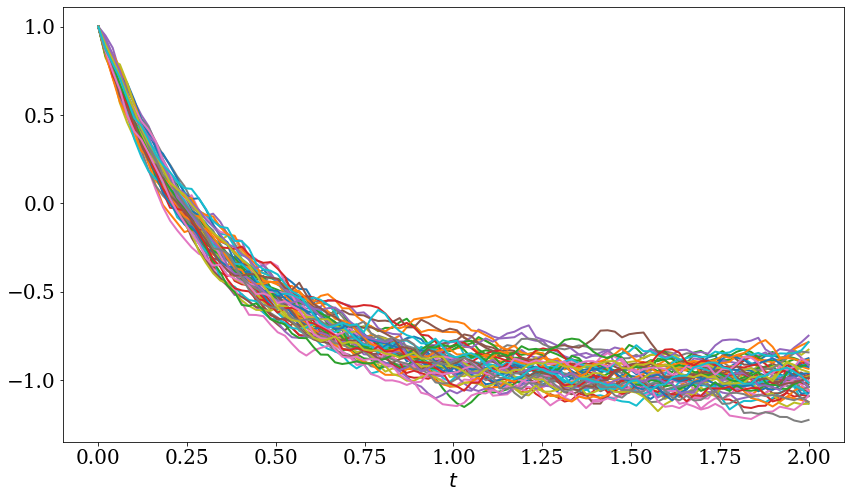

In [8]:
# Calculate normalization constants
normalizations = (T/2 - np.sin(2*T*roots)/(4*roots))**(-1/2)
lambdas = sigma**2 / (theta**2 + roots**2)

# Simulated OU process
def karhunen_loeve_ou(m):
    x = mu + (x0 - mu)*np.exp(-theta*t)
    for alpha, lam, norm in zip(roots, lambdas, normalizations):
        increment = np.sqrt(lam) * np.sin(alpha*t) * norm
        x = x + np.tensordot(increment, np.random.randn(m), axes=0).T
    return x

fig, ax = plt.subplots()
x = karhunen_loeve_ou(50)
ax.plot(t, x.T)
ax.set_xlabel('$t$')
plt.show()

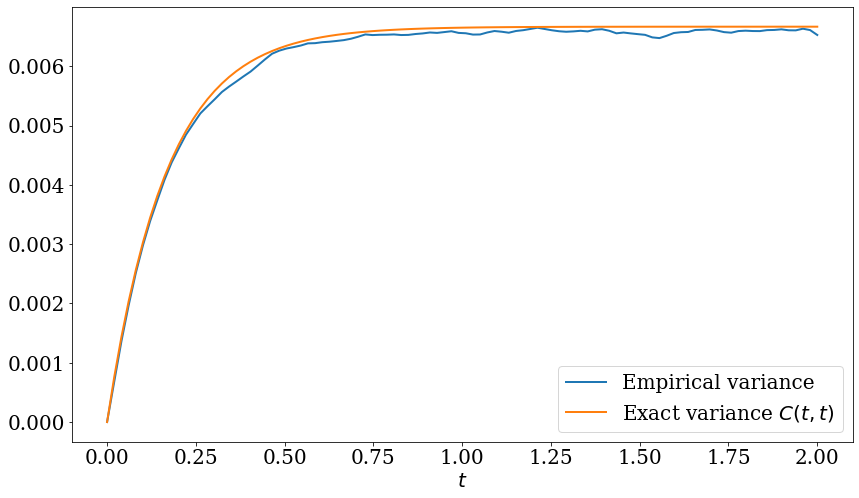

In [9]:
# Check that the empirical covariance matches the expected one
fig, ax = plt.subplots()
x = karhunen_loeve_ou(50000)
ax.plot(t, np.var(x, axis=0), label="Empirical variance")
ax.set_xlabel('$t$')
ax.plot(t, covariance_functions['Ornstein-Uhlenbeck'](t, t),
        label="Exact variance $C(t, t)$")
ax.legend()
plt.show()